# Error metrics
Below is detail about the metric we used to evaluate the models.
1. Error in goal prediction: Each model either gives a float value for predicted goals (eg Poisson Regression) or probability for different goals. For the latter we can calculate expexted goals using function mean_goals(). Let us call this mean by $\mu$. The error is then defined as $$\epsilon = \frac{1}{N}\sum_{i=1}^N (y_i - \mu_i )^2.$$
2. F-score for classification: For Poisson Regression we round the mean goal to nearest interger. This would be the prediction of the goal. For classification models the prediction is the most likely class. We then calculate the standard F1-score using sklearn library.

# Few comments on the model selection
1. Since we have around 10 features and ~700 samples, we are not in the regime of high-dimensional data. Hence we used ordinary least sqaure methods and did not care too much about issues commonly associated with high-dimensionality.
2. We did not use Lasso or penalized/regularized models. This is fine since our dimension of features is much small than number of samples. 
3. We only worked and looked at features with low level of multi-colinearity. We used VIF to throw/modify some features. 
4. We also used our knowledge of soccer to determine the features absolutely necessary for goals. E.g we know for sure that higher number of shots should lead to higher expected number of goals (this was also verified in 'expected_goals_predictor' notebook).

# Things that can be done 
##### Use a systematic feature selection. 
   1. Use Principal Component Analysis (PCA) instead of direct features.
   2. Use Lasso on Poisson regression. But this is not standard method in any package I know. This should be easy to implement though. 
   3. For KNN a systematic search for optimal neighbors can be done.

In [203]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as pl
import seaborn as sns
from seaborn import set_style, pairplot, swarmplot,boxplot
set_style(None)

In [2]:
from scipy.special import factorial
## Sklearn packages
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression, PoissonRegressor, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, precision_recall_fscore_support

## statsmodel packages
import statsmodels.api as sm

from helper_functions import addline

In [3]:
home_data = pd.read_csv('data/home_data_18_19.csv',index_col=0)
away_data = pd.read_csv('data/away_data_18_19.csv',index_col=0)
home_data.head()

,goals,passes,possession,shots,shots_on_target,xg,opp_goals,opp_passes,opp_shots,opp_shots_on_target,opp_xg,Win,Draw
0,2,485.0,46.3,8.0,6.0,1.25,1,543.0,13.0,4.0,1.46,1,0
1,0,773.0,71.7,12.0,5.0,1.54,1,303.0,11.0,5.0,1.27,0,0
2,0,420.0,38.3,11.0,5.0,1.30,2,675.0,15.0,6.0,1.63,0,0
3,1,313.0,35.4,15.0,6.0,1.57,5,579.0,12.0,7.0,1.62,0,0
4,3,553.0,55.1,21.0,7.0,2.15,1,473.0,8.0,5.0,1.15,1,0


We find that 'xg' and 'opp_xg' has high VIF. This is not surprising based on results from notebook 'exprected_goals_predictor'. We cannpt use these features directly for linear regression. 

Similarly we ignore 'passes' and 'opp_passes' as they are highly correlated with 'possession'.

To deal with this we define new vairables:
1. xg_per_shots = xg / shots_on_target \
   xg_per_shots is a measure of the efficiency of the shots taken on target. If it is high then probably the shots on target are of high quality.
2. quality_of_shots = shots_on_target / shots
   If this is high then lot of shots taken by the team are on target and are of good quality.





In [35]:
def prepare_train_X(X,y):
    X['possession_per_pass'] = X['possession']/X['passes']

    X['xg_per_shot'] = X['xg'] / X['shots_on_target']
    X.loc[X['xg_per_shot']==np.inf,'xg_per_shot'] = 0

    X['quality_of_shots'] = X['shots_on_target'] / X['shots']
    X.loc[X['shots']==0,'quality_of_shots']=0

    X['opp_xg_per_shot'] = X['opp_xg']/ X['opp_shots']
    X.loc[X['opp_xg_per_shot']==np.inf,'opp_xg_per_shot'] = 0

    X['opp_quality_of_shots'] = X['opp_shots_on_target'] / X['opp_shots']
    X.loc[X['opp_shots']==0,'opp_quality_of_shots']=0

    X = X.drop(columns=['goals','passes','opp_passes','xg','opp_xg','shots','opp_shots'])

    X['Loss'] = 0
    X.loc[(X['Win']==0) * (X['Draw']==0),'Loss'] = 1

    X['win_opp_goals'] = X['Win'] * X['opp_goals']

    ## Goals = 6 only occur 4 times. Thus these points have high leverage and we need to remove them
    X = X[y<6]
    y = y[y<6]
    y = y[X['opp_goals']<6]
    X = X.loc[X['opp_goals']<6]

    return X,y


def mean_goals(probs,goal_range=np.arange(0,6,1)):
    return np.sum(probs*goal_range,axis=-1)

In [36]:
X = pd.DataFrame({'intercept':np.ones(home_data.shape[0] + away_data.shape[0])})
cols = home_data.columns
for col in cols:
    X[col] = list(home_data[col]) + list(away_data[col])
y = X['goals']

X,y = prepare_train_X(X,y)

y.shape

(752,)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_df = pd.DataFrame(columns=['VIF'])
for i,col in enumerate(X.columns[1:]):
    var = vif(X,i+1)
    vif_df.loc[col] = [var]
    # print("VIF for {}:".format(col), var)
    # print("p-value for {}:".format(col),results.pvalues.iloc[i])
    # print()
vif_df

/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF
possession,1.788439
shots_on_target,2.851413
opp_goals,3.179581
opp_shots_on_target,4.225263
Win,inf
Draw,inf
possession_per_pass,1.049644
xg_per_shot,1.508999
quality_of_shots,2.124860
opp_xg_per_shot,2.649688


We find all vairables to have low VIF, that is, there is low multi-colinearity in the data. This make the errors in the estimates more robust to changes. This might come at a cost of accuracy though.

We find that adding interaction between 'Win' and 'opp_goals' is important to the problem. This can be seen from the plot below. The slope for 'Win'=1 is much higher than slope 'Win'=0

{0: 0.0,
 1: 0.5378151260504201,
 2: 0.7672955974842768,
 3: 1.0125,
 4: 1.064516129032258,
 5: 0.6428571428571429,
 6: nan}

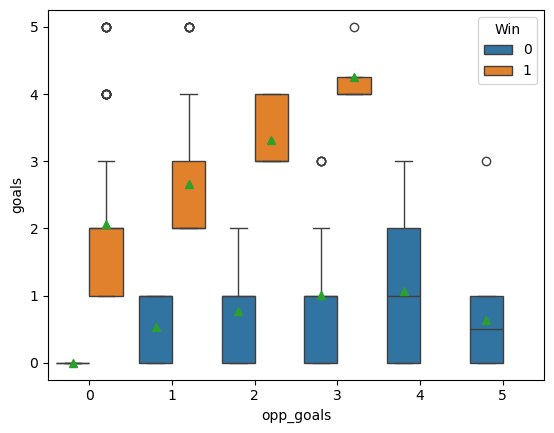

In [38]:
boxplot(x=X['opp_goals'],y=y,hue=X['Win'],showmeans=True)
{g:np.mean(y[(X['opp_goals']==g)*(X['Win']==0)]) for g in range(7)}

### Poisson Regression

In [40]:
X.columns

Index(['intercept', 'possession', 'shots_on_target', 'opp_goals',
       'opp_shots_on_target', 'Win', 'Draw', 'possession_per_pass',
       'xg_per_shot', 'quality_of_shots', 'opp_xg_per_shot',
       'opp_quality_of_shots', 'Loss', 'win_opp_goals'],
      dtype='object')

In [370]:
fit_on = ['intercept','shots_on_target','Win','Draw','quality_of_shots','opp_goals','win_opp_goals']
fit_on = ['intercept','opp_goals','shots_on_target','win_opp_goals','Win']

glm = sm.GLM(y,X[fit_on],family=sm.families.Poisson(link=sm.families.links.identity()))
results = glm.fit()
results.summary()

/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  752
Model:                            GLM   Df Residuals:                      747
Model Family:                 Poisson   Df Model:                            4
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 31 Jul 2024   Deviance:                       407.33
Time:                        14:44:25   Pearson chi2:                     357.
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.1938      0.028     -7.030      0.000      -0.248      -0.140
opp_goals           0.1938      0.028      7.030      0.000       0.140       0.248
shots_on_target     0.1469      0.011     13.761      0.000       0.126       0.168
win_opp_goals       0.3645      0.141      2.590      0.010       0.089       0.640
Win                 1.4521      0.126     11.570      0.000       1.206       1.698
===================================================================================
"""

In [9]:
mu = np.array(results.mu)
goals = np.array(y)[:]
pred_prob = np.power(mu,goals) * np.exp(-mu) / factorial(goals)

In [10]:
{g:np.mean(mu[goals==g]) for g in np.sort(goals)}

{0: 0.5902281593718689,
 1: 1.0260762867278643,
 2: 1.8849367749803216,
 3: 2.482782492403085,
 4: 2.8266366321214824,
 5: 3.064712448039631}

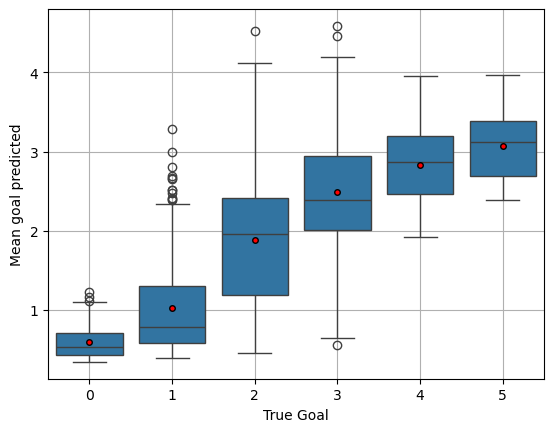

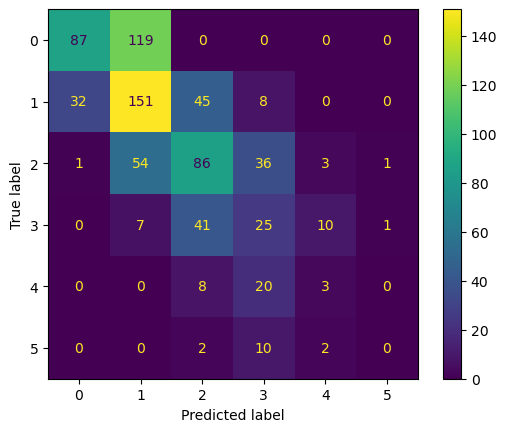

In [11]:
# fig,ax = subplots(1,1)
# ax.scatter(goals,predicted_mu)
boxplot(x=goals,y=mu,showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'}).grid(True)
pl.xlabel('True Goal')
pl.ylabel('Mean goal predicted')
sk.metrics.ConfusionMatrixDisplay.from_predictions(y,np.round(mu),labels=[0,1,2,3,4,5])

In [12]:
precision_recall_fscore_support(y,np.round(mu),labels=[0,1,2,3,4,5],average=None) # outputs Precision, Recall, F-score, and support in this order

(array([0.725     , 0.45619335, 0.47252747, 0.25252525, 0.16666667,
        0.        ]),
 array([0.4223301 , 0.63983051, 0.47513812, 0.29761905, 0.09677419,
        0.        ]),
 array([0.53374233, 0.53262787, 0.4738292 , 0.27322404, 0.12244898,
        0.        ]),
 array([206, 236, 181,  84,  31,  14]))

Looking at the distribution of residuals.

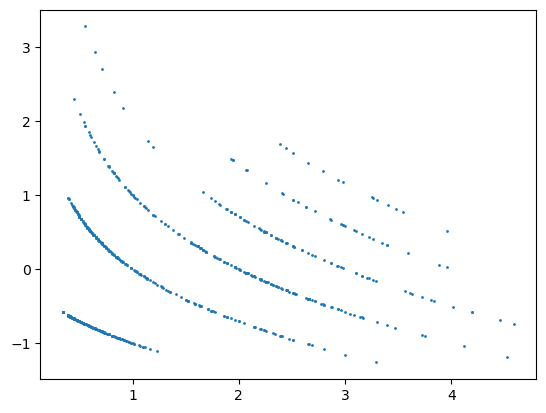

In [13]:
fig,ax=subplots(1,1)
ax.scatter(results.fittedvalues,results.resid_pearson,s=1)

## Classfication algo for goals

Since we only have 6 possibilities of goals we can also try implementing classication algorithms for predicting goal.

### Logistic Regression

error:  0.6368384435849215


/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([0.59307359, 0.45116279, 0.44827586, 0.4       , 0.        ,
        0.        ]),
 array([0.66504854, 0.41101695, 0.64640884, 0.21428571, 0.        ,
        0.        ]),
 array([0.62700229, 0.43015521, 0.52941176, 0.27906977, 0.        ,
        0.        ]),
 array([206, 236, 181,  84,  31,  14]))

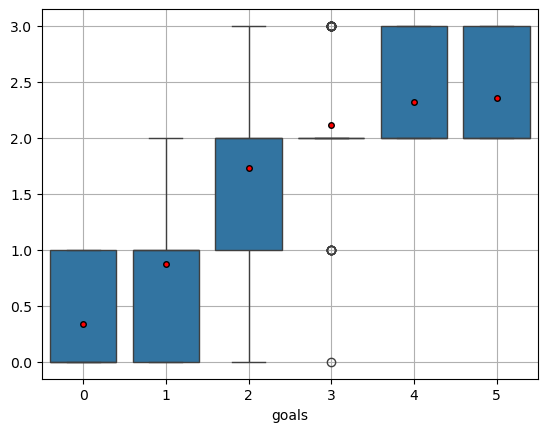

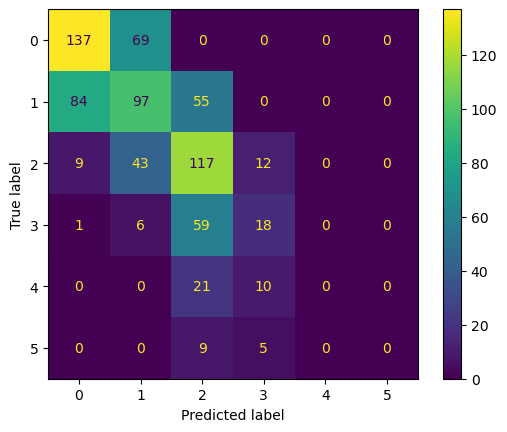

In [14]:
# fit_on = X.columns.drop(['Loss','opp_shots_on_target','opp_quality_of_shots','opp_xg_per_shot','possession','xg_per_shot'])

fit_on = ['intercept','shots_on_target','Win','Draw','quality_of_shots']
X2 = X[fit_on]

goal_lr = LogisticRegression(fit_intercept=False,random_state=100,max_iter=2000)
goal_lr = goal_lr.fit(X2,y)
y_pred = goal_lr.predict(X2)
y_probs = goal_lr.predict_proba(X2)
mu_lr = mean_goals(y_probs)
error = np.mean((y-mu_lr)**2)
print('error: ', error)
# fig,ax = subplots(1,1)
# ax.scatter(goals,predicted_mu)
im = boxplot(x=y,y=y_pred,showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'})
im.grid(True)
sk.metrics.ConfusionMatrixDisplay.from_predictions(y,y_pred,labels=[0,1,2,3,4,5])

precision_recall_fscore_support(y,y_pred,labels=[0,1,2,3,4,5],average=None) # outputs Precision, Recall, F-score, and support in this order

### Discriminant Analysis

LDA error:  0.6318239348461031


/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([0.5907173 , 0.44761905, 0.48230088, 0.31168831, 0.        ,
        0.        ]),
 array([0.67961165, 0.39830508, 0.60220994, 0.28571429, 0.        ,
        0.        ]),
 array([0.63205418, 0.42152466, 0.53562654, 0.29813665, 0.        ,
        0.        ]),
 array([206, 236, 181,  84,  31,  14]))

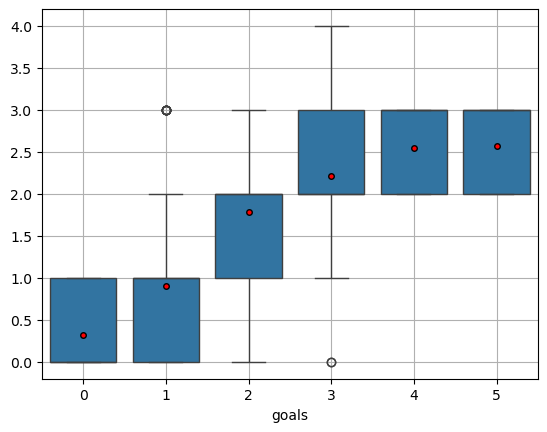

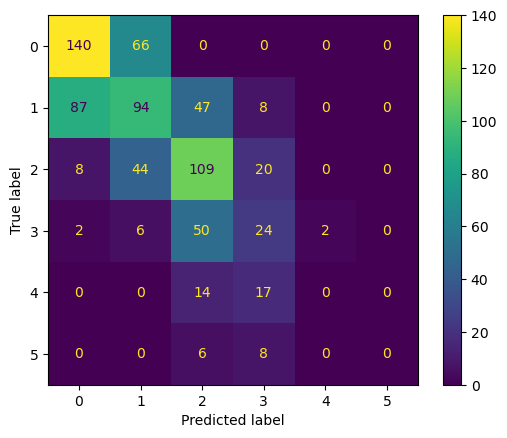

In [15]:
fit_on = ['intercept','shots_on_target','Win','Draw','quality_of_shots']
X2 = X[fit_on]

goal_lda = LinearDiscriminantAnalysis()
goal_lda = goal_lda.fit(X2.drop(columns='intercept'),y)
y_pred = goal_lda.predict(X2.drop(columns='intercept'))
y_probs = goal_lda.predict_proba(X2.drop(columns='intercept'))
mu_lda = mean_goals(y_probs)
error = np.mean((y-mu_lda)**2)
print('LDA error: ', error)
# fig,ax = subplots(1,1)
# ax.scatter(goals,predicted_mu)
boxplot(x=y,y=y_pred,showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'}).grid(True)

sk.metrics.ConfusionMatrixDisplay.from_predictions(y,y_pred,labels=[0,1,2,3,4,5])

precision_recall_fscore_support(y,y_pred,labels=[0,1,2,3,4,5],average=None) # outputs Precision, Recall, F-score, and support in this order

### KNeighbor Classification

We find that n_neighbors=2 is the best model for our case

LDA error:  0.4794714095744681


(array([0.63286713, 0.58851675, 0.63157895, 0.53164557, 0.61111111,
        0.5       ]),
 array([0.87864078, 0.52118644, 0.53038674, 0.5       , 0.35483871,
        0.28571429]),
 array([0.73577236, 0.55280899, 0.57657658, 0.51533742, 0.44897959,
        0.36363636]),
 array([206, 236, 181,  84,  31,  14]))

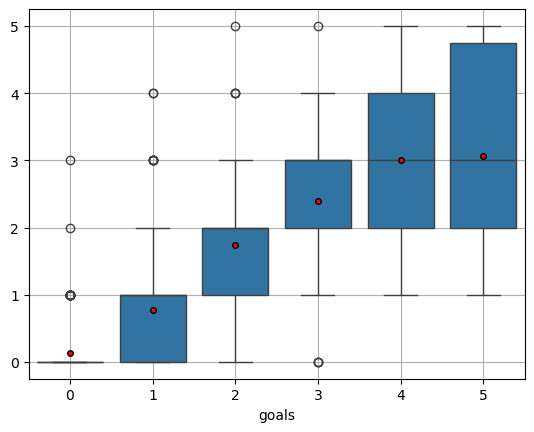

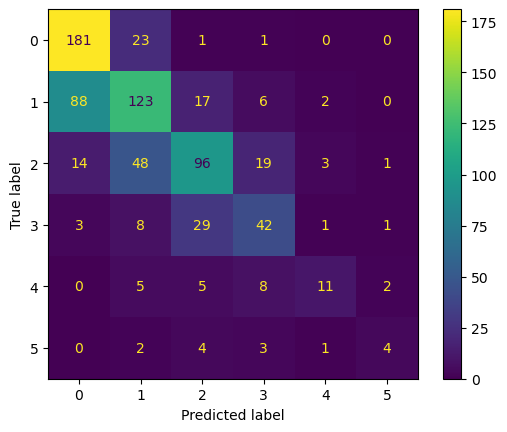

In [34]:
fit_on = ['intercept','shots_on_target','Win','Draw','quality_of_shots']
X2 = X[fit_on]

goal_knn = KNeighborsClassifier(n_neighbors=4)
goal_knn = goal_knn.fit(X2.drop(columns='intercept'),y)
y_pred = goal_knn.predict(X2.drop(columns='intercept'))
y_probs = goal_knn.predict_proba(X2.drop(columns='intercept'))
mu_knn = mean_goals(y_probs)
error = np.mean((y-mu_knn)**2)
print('LDA error: ', error)
# fig,ax = subplots(1,1)
# ax.scatter(goals,predicted_mu)
boxplot(x=y,y=y_pred,showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'}).grid(True)

sk.metrics.ConfusionMatrixDisplay.from_predictions(y,y_pred,labels=[0,1,2,3,4,5])

precision_recall_fscore_support(y,y_pred,labels=[0,1,2,3,4,5],average=None) # outputs Precision, Recall, F-score, and support in this order

### Cross-validation study of Poisson regression

In [242]:
def add_error(y_exact,y_pred,mu,error_df,f_score_df,model):
    error = np.mean((y_exact-mu)**2) 
    temp = pd.DataFrame([[error,model]],columns=error_df.columns)
    error_df = pd.concat([error_df,temp],axis=0,ignore_index=True)

    _,_,fscore,_ = precision_recall_fscore_support(y_exact,y_pred,average=None,zero_division=0,labels=[0,1,2,3,4,5])
    temp = pd.DataFrame([list(fscore)+[model]],columns=f_score_df.columns)
    f_score_df = pd.concat([f_score_df,temp],ignore_index=True)

    return error_df, f_score_df


def get_errors(X,y,model,error_df,f_score_df,model_name,drop_intercept=False):
    if drop_intercept:
        if 'intercept' in X.columns:
            X = X.drop(columns='intercept')
    y_pred = model.predict(X)
    mu = mean_goals(model.predict_proba(X))
    error_df, f_score_df = add_error(y,y_pred,mu,
                                        error_df,f_score_df,model_name)
    return error_df, f_score_df


In [338]:
def cross_val(fit_on,n_neig,n_splits=5):
    print('Features used for fitting: ',list(fit_on),'\n')
    X2 = X[fit_on]
    kfold = KFold(n_splits=n_splits,shuffle=True,random_state=1000)


    train_error_df = pd.DataFrame(columns=['Train error','Model'])
    test_error_df = pd.DataFrame(columns=['Test error','Model'])
    train_f_score_df = pd.DataFrame(columns=['0','1','2','3','4','5','Model'])
    test_f_score_df = pd.DataFrame(columns=['0','1','2','3','4','5','Model'])

    for train_index, test_index in kfold.split(X2,y):
        X2_t = X2.iloc[train_index]
        y_t = y.iloc[train_index]
        X2_ho = X2.iloc[test_index]
        y_ho = y.iloc[test_index]
        
        goal_poi = sm.GLM(y_t,X2_t,family=sm.families.Poisson(link=sm.families.links.log()))
        goal_poi = goal_poi.fit()
        mu = (goal_poi.predict(X2_t))
        y_pred = np.round(mu)
        test_mu = goal_poi.predict(X2_ho)
        test_pred = np.round(test_mu)
        train_error_df, train_f_score_df = add_error(y_t,y_pred,mu,
                                            train_error_df,train_f_score_df,'Poisson')
        test_error_df, test_f_score_df = add_error(y_ho,test_pred,test_mu,
                                            test_error_df,test_f_score_df,'Poisson')


        goal_lr = LogisticRegression(fit_intercept=False,random_state=100,max_iter=2000)
        goal_lr = goal_lr.fit(X2_t,y_t)
        train_error_df, train_f_score_df = get_errors(X2_t,y_t,goal_lr,
                                                    train_error_df,train_f_score_df,
                                                    'Logistic',drop_intercept=False)
        test_error_df, test_f_score_df = get_errors(X2_ho,y_ho,goal_lr,
                                                    test_error_df,test_f_score_df,
                                                    'Logistic',drop_intercept=False)

    

        goal_lda = LinearDiscriminantAnalysis()
        if 'intercept' in X2_t:
            goal_lda = goal_lda.fit(X2_t.drop(columns='intercept'),y_t)
        else:
            goal_lda = goal_lda.fit(X2_t,y_t)
        train_error_df, train_f_score_df = get_errors(X2_t,y_t,goal_lda,
                                                    train_error_df,train_f_score_df,
                                                    'LDA',drop_intercept=True)
        test_error_df, test_f_score_df = get_errors(X2_ho,y_ho,goal_lda,
                                                    test_error_df,test_f_score_df,
                                                    'LDA',drop_intercept=True)



        goal_knn = KNeighborsClassifier(n_neighbors=n_neig)
        if 'intercept' in X2_t:
            goal_knn = goal_knn.fit(X2_t.drop(columns='intercept'),y_t)
        else:
            goal_knn = goal_knn.fit(X2_t,y_t)    
        train_error_df, train_f_score_df = get_errors(X2_t,y_t,goal_knn,
                                                    train_error_df,train_f_score_df,
                                                    'KNN',drop_intercept=True)
        test_error_df, test_f_score_df = get_errors(X2_ho,y_ho,goal_knn,
                                                    test_error_df,test_f_score_df,
                                                    'KNN',drop_intercept=True)



        goal_nb = GaussianNB()
        if 'intercept' in X2_t:
            goal_nb = goal_nb.fit(X2_t.drop(columns='intercept'),y_t)
        else:
            goal_nb = goal_nb.fit(X2_t,y_t)
        train_error_df, train_f_score_df = get_errors(X2_t,y_t,goal_nb,
                                                    train_error_df,train_f_score_df,
                                                    'GaussNB',drop_intercept=True)
        test_error_df, test_f_score_df = get_errors(X2_ho,y_ho,goal_nb,
                                                    test_error_df,test_f_score_df,
                                                    'GaussNB',drop_intercept=True)



    test_f_score_mean = test_f_score_df.groupby(['Model']).mean()
    train_f_score_mean = train_f_score_df.groupby(['Model']).mean()
    test_f_score_mean['Test F-score'] = test_f_score_mean[['0','1','2','3','4','5']].mean(axis=1)
    train_f_score_mean['Train F-score'] = train_f_score_mean[['0','1','2','3','4','5']].mean(axis=1)

    test_error_mean = test_error_df.groupby(['Model']).mean()
    train_error_mean = train_error_df.groupby(['Model']).mean()

    test_f_score_mean.index.name = 'Test F-score for different models'
    train_f_score_mean.index.name = 'Train F-score for different models'

    return train_error_mean, train_f_score_mean, test_error_mean, test_f_score_mean, train_f_score_df, test_f_score_df





We now fit various models for different feature set.

In [224]:
fit_on = ['intercept','shots_on_target','Win','Draw','opp_goals','win_opp_goals']
train_error_mean, train_f_score_mean, test_error_mean, test_f_score_mean, _, _ = cross_val(fit_on,n_neig=5,n_splits=5)

result_df = pd.concat([train_f_score_mean['Train F-score'],test_f_score_mean['Test F-score'],train_error_mean['Train error'],test_error_mean['Test error']],axis=1)
result_df

Features used for fitting:  ['intercept', 'shots_on_target', 'Win', 'Draw', 'opp_goals', 'win_opp_goals'] 



,Train F-score,Test F-score,Train error,Test error
GaussNB,0.162857,0.139044,2.374601,2.393813
KNN,0.535450,0.408170,0.425469,0.526332
LDA,0.427455,0.402835,0.500624,0.528253
Logistic,0.374671,0.363195,0.521691,0.547828
Poisson,0.413182,0.405478,0.510693,0.528293


Let us now add feature 'quality_of_shots'. We find no significant improvement in the performance. This suggests that quality of shots does not has significant relation with the goals scored.

In [225]:
fit_on = ['intercept','shots_on_target','quality_of_shots','Win','Draw','opp_goals','win_opp_goals']
train_error_mean, train_f_score_mean, test_error_mean, test_f_score_mean,_,_ = cross_val(fit_on,n_neig=5,n_splits=5)

result_df = pd.concat([train_f_score_mean['Train F-score'],test_f_score_mean['Test F-score'],train_error_mean['Train error'],test_error_mean['Test error']],axis=1)
result_df

Features used for fitting:  ['intercept', 'shots_on_target', 'quality_of_shots', 'Win', 'Draw', 'opp_goals', 'win_opp_goals'] 



,Train F-score,Test F-score,Train error,Test error
GaussNB,0.170790,0.148015,2.309855,2.323508
KNN,0.565784,0.389427,0.345776,0.525064
LDA,0.422574,0.397270,0.496483,0.526700
Logistic,0.376416,0.361588,0.521151,0.548685
Poisson,0.402803,0.394022,0.504259,0.524794


We go back to the previous model without the 'quality_of_shot' feature.

In [364]:
test_error_mean

,Test error
Model,
GaussNB,2.389137
KNN,0.497479
LDA,0.519150
Logistic,0.537781
Poisson,0.524951


Features used for fitting:  ['intercept', 'shots_on_target', 'Win', 'Draw', 'opp_goals', 'win_opp_goals'] 



Text(0.5, 0, 'Model')

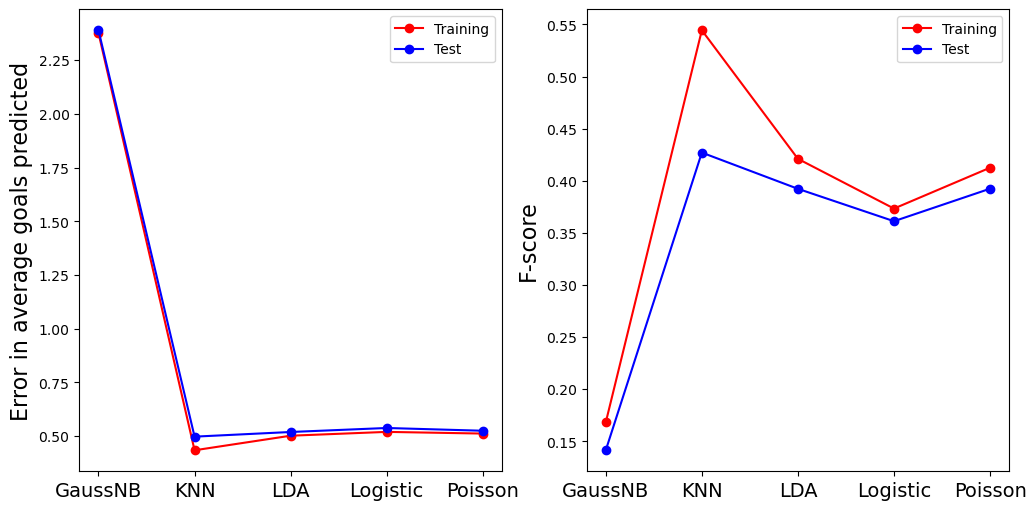

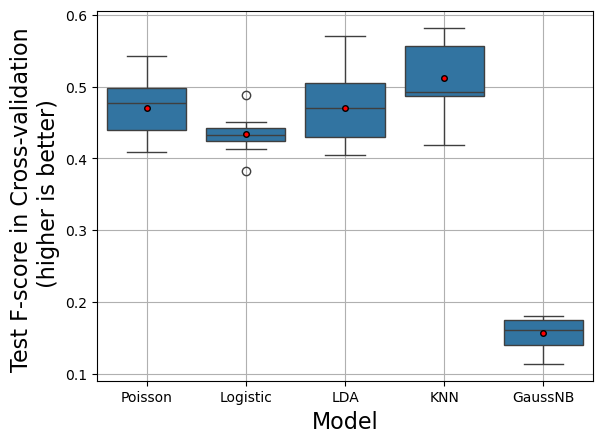

In [365]:
fit_on = ['intercept','shots_on_target','Win','Draw','opp_goals','win_opp_goals']
train_error_mean, train_f_score_mean, test_error_mean, test_f_score_mean, train_f_score,test_f_score = cross_val(fit_on,n_neig=5,n_splits=10)

model_order = list(train_error_mean.index)

fig,ax = subplots(1,2,figsize=(12,6))
ax[0].plot([0,1,2,3,4],train_error_mean.loc[model_order],'r-',marker='o',ms=6,label='Training')
ax[0].plot([0,1,2,3,4],test_error_mean.loc[model_order],'b-',marker='o',ms=6,label='Test')
ax[0].set_ylabel('Error in average goals predicted',fontsize=16)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(model_order,fontsize=14)
ax[0].legend()

ax[1].plot([0,1,2,3,4],train_f_score_mean.loc[model_order]['Train F-score'],'r-',marker='o',ms=6,label='Training')
ax[1].plot([0,1,2,3,4],test_f_score_mean.loc[model_order]['Test F-score'],'b-',marker='o',ms=6,label='Test')
ax[1].set_ylabel('F-score',fontsize=16)
ax[1].set_xticks(range(5))
ax[1].set_xticklabels(model_order,fontsize=14)
ax[1].legend()

fig,ax = subplots(1,1)
boxplot(x=test_f_score['Model'],y=test_f_score.iloc[:,:5].mean(axis=1),showmeans=True, meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'},ax=ax).grid(True)
ax.set_ylabel('Test F-score in Cross-validation \n (higher is better)',fontsize=16)
ax.set_xlabel('Model',fontsize=16)

We also look at the F-score for individual classes. Some classes might be easy to predict compared to others.

In [340]:
train_f_score_mean.style.set_caption("Train F-score averaged over validation sets. The columns are number of goals and the values are the F-score for corresponding models")

,0,1,2,3,4,5,Train F-score
Train F-score for different models,,,,,,,
GaussNB,0.630949,0.000000,0.000000,0.000000,0.171740,0.206677,0.168228
KNN,0.802261,0.718736,0.641646,0.484010,0.349107,0.270703,0.544411
LDA,0.763550,0.525204,0.508444,0.373691,0.327080,0.028571,0.421090
Logistic,0.738945,0.557574,0.560910,0.382756,0.000000,0.000000,0.373364
Poisson,0.744656,0.540957,0.568164,0.402930,0.185868,0.032817,0.412565


In [341]:
test_f_score_mean.style.set_caption("Test F-score averaged over validation sets. The columns are number of goals and the values are the F-score for corresponding models")

,0,1,2,3,4,5,Test F-score
Test F-score for different models,,,,,,,
GaussNB,0.632766,0.000000,0.000000,0.000000,0.149184,0.066905,0.141476
KNN,0.756559,0.665768,0.597769,0.378976,0.163333,0.000000,0.427068
LDA,0.756196,0.514638,0.497242,0.314469,0.271349,0.000000,0.392316
Logistic,0.736174,0.541795,0.532703,0.356757,0.000000,0.000000,0.361238
Poisson,0.738650,0.532518,0.561539,0.377437,0.144444,0.000000,0.392431


Text(0, 0.5, 'Test F-score')

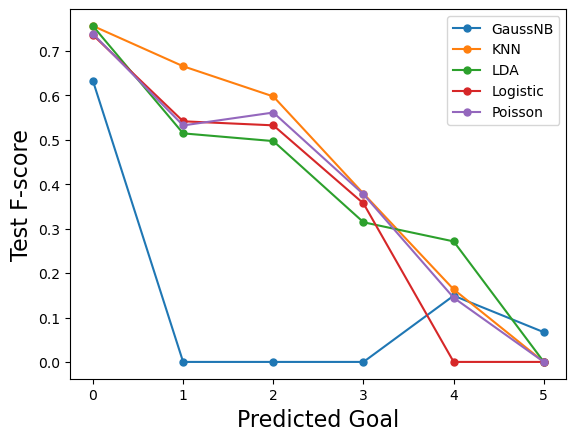

In [337]:
fig,ax = subplots(1,1)
models = test_f_score_mean.index
[ax.plot(test_f_score_mean.loc[i][:6],label=i,marker='o',ms=5) for i in models]
ax.legend()
ax.set_xlabel('Predicted Goal',fontsize=16)
ax.set_ylabel('Test F-score',fontsize=16)

We now summarize our results below.

## Results and Observations
1. KNN classifier seem to overfit the data. Training error is much less than testing error. Training F-score is more than test F-score. 
2. Performance of Poisson Regression, Logistic Regression, and Linear Discriminant Analysis seem similar. 
 Poisson is preferred as we can make various inferences about the relation between the output and input. Also, Poisson Regression seems to have marginally better performance compared to Logistic and LDA.
 3. GaussianNB performs really bad. This implies that the assumption of the features being uncorrelated is not good. In fact, interestingly, the accuracy of GaussianNB is same as one based on naive predictor (the naive predictor always predict the outcome which has occured the most in the output data)
 4. F-score for goals = 0,1,2 is larger than 0.55. On the other hand, it is really low for goals=3,4,5. This suggests that predicting matches with less number of goals is easier. This can be for various reasons. One potential reason is that number of samples with goals=3,4,5 is much less than for goals=0,1,2. Thus the model is able to better learn the relation between features and goals for 0,1,2 goals.

## Testing on Euros 24 data

We test the above models on the Euro 2024 data. 

In [228]:
test = pd.read_csv('data/away_data_euro.csv',index_col=0)
test.head()
test_X = pd.DataFrame({'intercept':np.ones(test.shape[0])})
cols = test.columns
for col in cols:
    test_X[col] = list(test[col])
test_y = test['goals']
test_X,test_y = prepare_train_X(test_X,test_y)

fit_on = ['intercept','shots_on_target','Win','Draw','opp_goals','win_opp_goals']

In [259]:
euro_errors = pd.DataFrame(columns=['Goal Error', 'Model'])
euro_f_score = pd.DataFrame(columns=['0','1','2','3','4','5','Model'])

goal_poi = sm.GLM(y,X[fit_on],family=sm.families.Poisson(link=sm.families.links.log()))
goal_poi = goal_poi.fit()
mu = (goal_poi.predict(test_X[fit_on]))
y_pred = np.round(y_pred)
_,_,fscore,_ = precision_recall_fscore_support(test_y,y_pred,average=None,zero_division=0,labels=[0,1,2,3])

euro_errors,euro_f_score = add_error(test_y,y_pred,mu,euro_errors,euro_f_score,'Poisson')

goal_lr = LogisticRegression(fit_intercept=False,random_state=100,max_iter=2000)
goal_lr = goal_lr.fit(X[fit_on],y)

euro_errors, euro_f_score = get_errors(test_X[fit_on],test_y,goal_lr,
                                            euro_errors,euro_f_score,
                                            'Logistic',drop_intercept=False)

goal_lda = LinearDiscriminantAnalysis()
goal_lda = goal_lda.fit(X[fit_on].drop(columns='intercept'),y)
euro_errors, euro_f_score = get_errors(test_X[fit_on],test_y,goal_lda,
                                            euro_errors,euro_f_score,
                                            'LDA',drop_intercept=True)


goal_knn = KNeighborsClassifier(n_neighbors=5)
goal_knn = goal_knn.fit(X[fit_on].drop(columns='intercept'),y)
euro_errors, euro_f_score = get_errors(test_X[fit_on],test_y,goal_knn,
                                            euro_errors,euro_f_score,
                                            'KNN',drop_intercept=True)

goal_nb = GaussianNB()
goal_nb = goal_nb.fit(X[fit_on].drop(columns='intercept'),y)
euro_errors, euro_f_score = get_errors(test_X[fit_on],test_y,goal_nb,
                                            euro_errors,euro_f_score,
                                            'GaussNB',drop_intercept=True)

euro_errors.set_index('Model',inplace=True)
euro_f_score.set_index('Model',inplace=True)
euro_f_score['Test F-score'] = euro_f_score[['0','1','2','3','4','5']].mean(axis=1)

In [266]:
result_df = pd.concat([euro_f_score['Test F-score'],euro_errors['Goal Error'],train_f_score_mean['Train F-score'],train_error_mean['Train error']],axis=1)
result_df.rename(columns={'Train error': 'Train Goal Error'},inplace=True)
result_df

,Test F-score,Goal Error,Train F-score,Train Goal Error
Poisson,0.448776,0.251917,0.413182,0.510693
Logistic,0.442734,0.324460,0.374671,0.521691
LDA,0.346895,0.326599,0.427455,0.500624
KNN,0.382889,0.361600,0.535450,0.425469
GaussNB,0.100000,2.011797,0.162857,2.374601


Calculating precision and recall on the Euro set

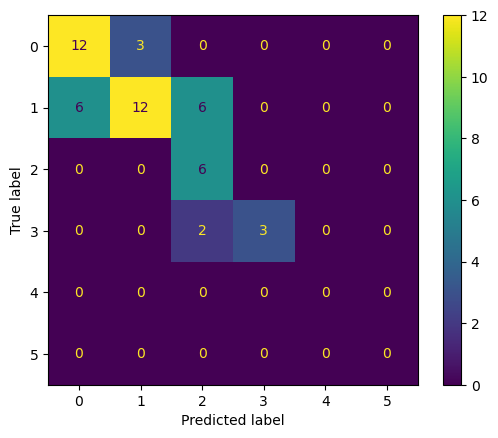

In [273]:
pres,recall,fscore,supp = precision_recall_fscore_support(test_y,np.round(goal_poi.predict(test_X[fit_on])),average=None,zero_division=0,labels=[0,1,2,3,4,5])


sk.metrics.ConfusionMatrixDisplay.from_predictions(test_y,np.round(goal_poi.predict(test_X[fit_on])),labels=[0,1,2,3,4,5])

In [279]:
avg_pres = pres[supp!=0].mean()
avg_recall = recall[supp!=0].mean()
print('Precision is ',avg_pres,'\n')
print('Recall is ',avg_recall,'\n')

Precision is  0.7238095238095239 

Recall is  0.725 



We see that the prediction of the model is accurate $72.4\%$ of the time.

/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)


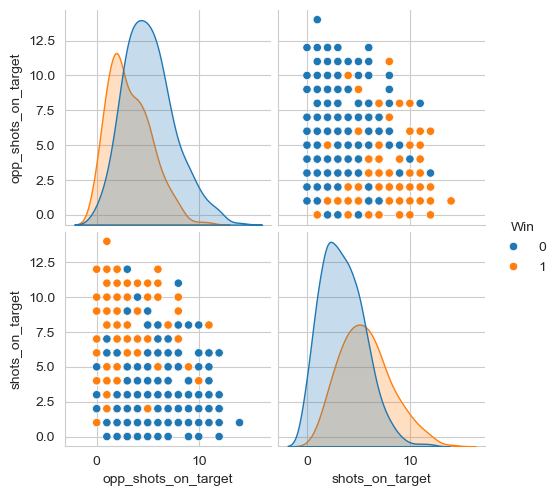

In [459]:
pairplot(X[['opp_shots_on_target','shots_on_target','Win']],hue='Win',palette=sns.color_palette("tab10"))

In [33]:
data = sm.datasets.star98.load()
data.endog.head()

,NABOVE,NBELOW
0,452.0,355.0
1,144.0,40.0
2,337.0,234.0
3,395.0,178.0
4,8.0,57.0


In [26]:


glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      283
Model Family:                  Binomial   Df Model:                           19
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -3000.5
Date:                  Tue, 23 Jul 2024   Deviance:                       4082.4
Time:                          11:15:41   Pearson chi2:                 4.05e+03
No. Iterations:                       5   Pseudo R-squ. (CS):              1.000
Covariance Type:              nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC

In [29]:
res.predict()

array([0.5854989 , 0.75311617, 0.50114075, 0.686423  , 0.3254407 ,
       0.686351  , 0.3328514 , 0.6568143 , 0.49932248, 0.50938476,
       0.23853108, 0.86322957, 0.46448915, 0.44203898, 0.66932405,
       0.73929991, 0.52033839, 0.43176856, 0.56410012, 0.59338801,
       0.34583156, 0.56126923, 0.49918087, 0.35632081, 0.20228968,
       0.17956955, 0.44927018, 0.48008273, 0.59945908, 0.58865705,
       0.3625851 , 0.3328329 , 0.74304611, 0.50931187, 0.53682992,
       0.56152508, 0.6012882 , 0.29144785, 0.29392836, 0.32180946,
       0.48408298, 0.23579667, 0.10985299, 0.156223  , 0.27801411,
       0.22599614, 0.18210986, 0.32273295, 0.22584067, 0.15699551,
       0.1525449 , 0.62018509, 0.2020261 , 0.51729314, 0.46762569,
       0.4171189 , 0.5971213 , 0.66108201, 0.27727755, 0.2353707 ,
       0.25271081, 0.23836628, 0.27814816, 0.3936563 , 0.27708665,
       0.61461857, 0.22623025, 0.41889539, 0.56507915, 0.35230049,
       0.46194706, 0.57382965, 0.21645818, 0.58381429, 0.17118

In [37]:
res.mu

array([0.5854989 , 0.75311617, 0.50114075, 0.686423  , 0.3254407 ,
       0.686351  , 0.3328514 , 0.6568143 , 0.49932248, 0.50938476,
       0.23853108, 0.86322957, 0.46448915, 0.44203898, 0.66932405,
       0.73929991, 0.52033839, 0.43176856, 0.56410012, 0.59338801,
       0.34583156, 0.56126923, 0.49918087, 0.35632081, 0.20228968,
       0.17956955, 0.44927018, 0.48008273, 0.59945908, 0.58865705,
       0.3625851 , 0.3328329 , 0.74304611, 0.50931187, 0.53682992,
       0.56152508, 0.6012882 , 0.29144785, 0.29392836, 0.32180946,
       0.48408298, 0.23579667, 0.10985299, 0.156223  , 0.27801411,
       0.22599614, 0.18210986, 0.32273295, 0.22584067, 0.15699551,
       0.1525449 , 0.62018509, 0.2020261 , 0.51729314, 0.46762569,
       0.4171189 , 0.5971213 , 0.66108201, 0.27727755, 0.2353707 ,
       0.25271081, 0.23836628, 0.27814816, 0.3936563 , 0.27708665,
       0.61461857, 0.22623025, 0.41889539, 0.56507915, 0.35230049,
       0.46194706, 0.57382965, 0.21645818, 0.58381429, 0.17118

In [174]:
xx = np.random.uniform(1,100,10000)
yy = np.array([np.random.poisson(lam=lam,size=1) for lam in xx]).flatten()
trial_res = sm.GLM(yy,np.vstack([np.ones(len(xx)),xx]).T,family=sm.families.Poisson(link=sm.families.links.identity()))
trial_res = trial_res.fit()

/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',

In [338]:
trial_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                 Poisson   Df Model:                            1
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32382.
Date:                Tue, 23 Jul 2024   Deviance:                       10097.
Time:                        15:15:10   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0554      0.061      0.911      0.362      -0.064       0.175
x1             0.9993      0.002    538.428      0.000       0.996       1.003
==============================================================================
"""

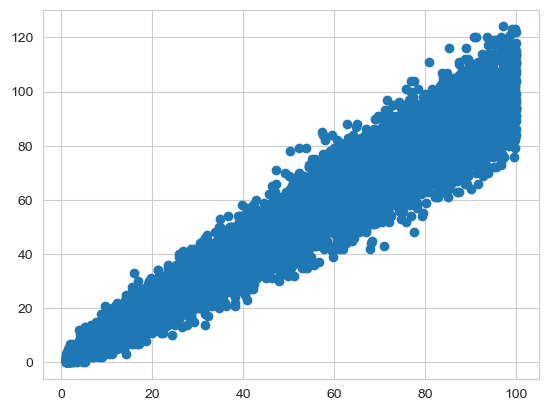

In [339]:
pl.scatter(xx,yy)

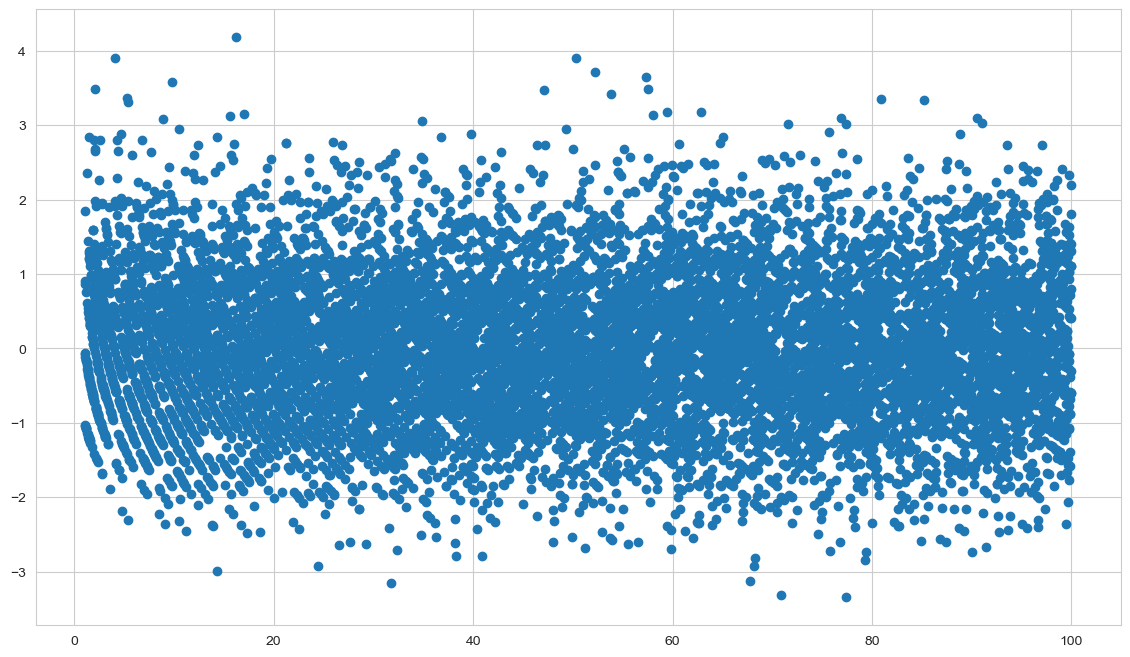

In [340]:
fig,ax=subplots(1,1,figsize=(14,8))
ax.scatter(trial_res.fittedvalues,trial_res.resid_pearson)
# ax[1].scatter(xx,np.log(trial_res.fittedvalues),s=2)